In [ ]:
# mount drive into colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%cd '/content/drive/MyDrive/Bazaar/classification'

/content/drive/MyDrive/Bazaar/classification


In [ ]:
#!unzip 'train_set.zip'
#!unzip 'test_set.zip'

***
# Imports

In [ ]:
%%capture
!pip install hazm
!pip install advertools
!pip install simpletransformers

In [ ]:
import pandas as pd

from __future__ import unicode_literals
from hazm import *
import re
import advertools as adv

from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel
from sklearn.metrics import f1_score, accuracy_score

***
# Load Data

In [ ]:
df_train = pd.read_csv('train_set.csv')
df_train.head()

,app_id,description_fa,label
0,0,<p>بازی مین روب یک برنامه فکری است که باید مین...,1
1,1,<p>دراین بازی تعدادی عکس برای شما نشان داده می...,1
2,2,<br>تلاش نافرجام برای درک «بوفالو»<br>مرگ پایا...,7
3,3,<p>فیلم نما ، برنامه ای برای دانلود و پخش آنلا...,7
4,4,<p>* این برنامه حاوی بیش از 500 عکس و ژست برای...,7


In [ ]:
df_test = pd.read_csv('test_set.csv')
df_test.head()

,app_id,description_fa
0,40000,<h4>در این برنامه یکی از بازی های جالب میکرو ر...
1,40001,<p>بازی آموزشی میلونر زبان انگلیسی برای تقویت ...
2,40002,<p> <b>موضوع رو می بینی و کلمات رو پیدا می کنی...
3,40003,<p>نرم افزار فول تلگرام در کنار تلگرام امكانات...
4,40004,<p> فکر می کنی خیلی سریع هستی نه؟ <br> ...


In [ ]:
print('Train Size: ', df_train.shape)
print('Test Size: ', df_test.shape)

Train Size:  (37899, 3)
Test Size:  (10000, 2)


In [ ]:
print('Missing Values in Train:\n', df_train.isna().sum())
print('Missing Values in Test:\n',  df_test.isna().sum())

Missing Values in Train:
 app_id            0
description_fa    0
label             0
dtype: int64
Missing Values in Test:
 app_id            0
description_fa    0
dtype: int64


In [ ]:
df_train['label'].value_counts()

9    4000
8    4000
7    4000
6    4000
4    4000
3    4000
1    4000
0    4000
2    3965
5    1934
Name: label, dtype: int64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f1947a9cf50>]],
      dtype=object)

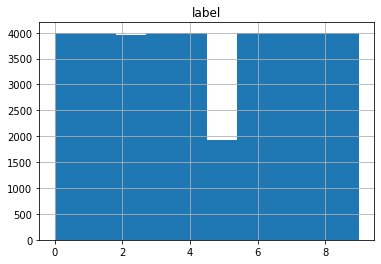

In [ ]:
df_train.hist(column='label')

***
# Data Cleaning

In [ ]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
        "]+", re.UNICODE)
    return re.sub(emoj, '', data)

In [ ]:
def preprocess_data(df):
  
  punc_en = '''!|()-[]{};:'"\, <>./?@#$%^&*_=+~1234567890'''
  punc_fa = '''؛؟«»،۰۱۲۳۴۵۶۷۸۹…'''
    
  # create empty columns
  df['description_words'] = ''
  df['description'] = ''

  # create objects
  normalizer = Normalizer()
  stemmer = Stemmer()
  lemmatizer = Lemmatizer()

  for i, data in enumerate(df['description_fa']):

    # remove the HTML tags
    data = re.compile(r'<[^>]+>').sub('', data)

    # remove english characters
    data = re.compile(r'[a-zA-Z]+').sub('', data)

    # remove emojis
    data = remove_emojis(data)

    # remove punctuations
    for word in data: 
      if (word in punc_en) or (word in punc_fa): 
          data = data.replace(word, ' ') 

    # remove non-breaking space 
    data = data.replace(u'\xa0', u' ') 
    
    # normalize data
    data = normalizer.normalize(data)
    data = data.replace(u'\u200c', u' ')
    
    # stemming
    data = stemmer.stem(data)
    data = lemmatizer.lemmatize(data)
    data = word_tokenize(data)

    # remove stop words
    for word in data:
      if word in adv.stopwords['persian']:
        data.remove(word)

    # remove customized stop words
    #with open('custom_stopwords.txt') as file:
    #  contents = file.read()
    #  for word in data:
    #    if word in contents:
    #      data.remove(word)

    # insert data to a new column as a list of words 
    df.at[i, 'description_words'] = data

    # insert data to a new column as a sequence
    df.at[i, 'description'] = ' '.join(data)

  return df

In [ ]:
# preprocess the train data
df_train = preprocess_data(df_train)
df_train.head()

,app_id,description_fa,label,description_words,description
0,0,<p>بازی مین روب یک برنامه فکری است که باید مین...,1,"[بازی, مین, روب, برنامه, فکری, که, مین, های, م...",بازی مین روب برنامه فکری که مین های موجود صفحه...
1,1,<p>دراین بازی تعدادی عکس برای شما نشان داده می...,1,"[دراین, بازی, تعدادی, عکس, نشان, سپس, شما, یکی...",دراین بازی تعدادی عکس نشان سپس شما یکی خاطر سپ...
2,2,<br>تلاش نافرجام برای درک «بوفالو»<br>مرگ پایا...,7,"[تلاش, نافرجام, درک, بوفالو, مرگ, پایان, ماجرا...",تلاش نافرجام درک بوفالو مرگ پایان ماجرا نیستچر...
3,3,<p>فیلم نما ، برنامه ای برای دانلود و پخش آنلا...,7,"[فیلم, نما, برنامه, ای, دانلود, پخش, آنلاین, ف...",فیلم نما برنامه ای دانلود پخش آنلاین فیلم سریا...
4,4,<p>* این برنامه حاوی بیش از 500 عکس و ژست برای...,7,"[برنامه, حاوی, عکس, ژست, مدل, عکاسی, شدنه, از,...",برنامه حاوی عکس ژست مدل عکاسی شدنه از کتاب مدل...


In [ ]:
# preprocess the test data
df_test = preprocess_data(df_test)
df_test.head()

,app_id,description_fa,description_words,description
0,40000,<h4>در این برنامه یکی از بازی های جالب میکرو ر...,"[این, برنامه, بازی, های, جالب, میکرو, برای, آم...",این برنامه بازی های جالب میکرو برای آماده بازی...
1,40001,<p>بازی آموزشی میلونر زبان انگلیسی برای تقویت ...,"[بازی, آموزشی, میلونر, زبان, انگلیسی, تقویت, ز...",بازی آموزشی میلونر زبان انگلیسی تقویت زبان انگ...
2,40002,<p> <b>موضوع رو می بینی و کلمات رو پیدا می کنی...,"[موضوع, بینی, کلمات, پیدا, می, کنی, شاد, سرگرم...",موضوع بینی کلمات پیدا می کنی شاد سرگرم حدس کلم...
3,40003,<p>نرم افزار فول تلگرام در کنار تلگرام امكانات...,"[نرم, افزار, فول, تلگرام, کنار, تلگرام, امکانا...",نرم افزار فول تلگرام کنار تلگرام امکاناتی بهتو...
4,40004,<p> فکر می کنی خیلی سریع هستی نه؟ <br> ...,"[کنی, سریع, هستی, می, تونی, خودتو, امتحان, کنی...",کنی سریع هستی می تونی خودتو امتحان کنی بازی سا...


In [ ]:
# save train and test dataframes into cleaned CSVs
df_train[['app_id','description','label']].to_csv('train_cleaned.csv', index=False)
df_test[['app_id','description']].to_csv('test_cleaned.csv', index=False)

***
# Text Classification Modeling
### Load cleaned data

In [ ]:
# load train data
df = pd.read_csv('train_cleaned.csv', usecols=['description', 'label'])

# split train and validation
df_train, df_val = train_test_split(df, test_size=0.1)

print('Train Shape: ', df_train.shape)
print('Validation Shape: ', df_val.shape)

Train Shape:  (34109, 2)
Validation Shape:  (3790, 2)


In [ ]:
# load test data
df_test = pd.read_csv('test_cleaned.csv', usecols=['app_id', 'description'])
X_test = df_test['description'].tolist() 

### Classification Model

In [ ]:
# define hyperparameter
train_args ={'num_train_epochs': 3,
             'overwrite_output_dir': True,
             'evaluate_during_training': True,
             #'evaluate_during_training_verbose': True,
             'no_save': True}

# create a ClassificationModel
model = ClassificationModel(
    'bert', 
    'HooshvareLab/bert-base-parsbert-uncased',
    num_labels = 10,
    #weight=[1, 1, 1, 1, 1, 2, 1, 1, 1, 1],
    args = train_args
)

2021-06-21 18:14:34,870 | INFO | filelock.py:274 | acquire | Lock 139746208891152 acquired on /root/.cache/huggingface/transformers/d3b7c3283a6a4ad4471f59269c9de8adadfab0b05eebf49a64e046fca56cdab2.58cfea678e7bd2c1de3bfd4a5357101526b9fbc32a994b9456047e55b0afbebe.lock


Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

2021-06-21 18:14:35,218 | INFO | filelock.py:318 | release | Lock 139746208891152 released on /root/.cache/huggingface/transformers/d3b7c3283a6a4ad4471f59269c9de8adadfab0b05eebf49a64e046fca56cdab2.58cfea678e7bd2c1de3bfd4a5357101526b9fbc32a994b9456047e55b0afbebe.lock
2021-06-21 18:14:35,572 | INFO | filelock.py:274 | acquire | Lock 139749669146960 acquired on /root/.cache/huggingface/transformers/a0c74740a336a1e8d32c2a24ddd7f51256436208e6ee744101707612f4e754a1.f8e37b3c71897e638d5002618547e9f2cee56b935e0cace3465cf4a33ae9f446.lock


Downloading:   0%|          | 0.00/654M [00:00<?, ?B/s]

2021-06-21 18:14:49,499 | INFO | filelock.py:318 | release | Lock 139749669146960 released on /root/.cache/huggingface/transformers/a0c74740a336a1e8d32c2a24ddd7f51256436208e6ee744101707612f4e754a1.f8e37b3c71897e638d5002618547e9f2cee56b935e0cace3465cf4a33ae9f446.lock
Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expec

Downloading:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

2021-06-21 18:14:52,289 | INFO | filelock.py:318 | release | Lock 139746208837904 released on /root/.cache/huggingface/transformers/b80b05f64dc19f3c880b7074ef09108d0bc244e4b6f50d6dba094da0f1c231fd.6699f2ee4745b6531f79b9781879071b6ace2d2768df83889391421fb44d4474.lock


In [ ]:
# train the model
model.train_model(df_train, eval_df=df_val)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:610: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
2021-06-21 18:15:05,766 | INFO | classification_utils.py:182 | build_classification_dataset |  Converting to features started. Cache is not used.


  0%|          | 0/34109 [00:00<?, ?it/s]

2021-06-21 18:15:21,657 | INFO | classification_utils.py:248 | build_classification_dataset |  Saving features into cached file cache_dir/cached_train_bert_128_10_2


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Running Epoch 0 of 3:   0%|          | 0/4264 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:936: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm
/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1393: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
2021-06-21 18:19:58,249 | INFO | classification_utils.py:182 | build_classification_dataset |  Converting to features started. Cache is not used.


  0%|          | 0/3790 [00:00<?, ?it/s]

2021-06-21 18:20:00,385 | INFO | classification_utils.py:248 | build_classification_dataset |  Saving features into cached file cache_dir/cached_dev_bert_128_10_2
2021-06-21 18:24:51,359 | INFO | classification_utils.py:182 | build_classification_dataset |  Converting to features started. Cache is not used.


  0%|          | 0/3790 [00:00<?, ?it/s]

2021-06-21 18:24:53,518 | INFO | classification_utils.py:248 | build_classification_dataset |  Saving features into cached file cache_dir/cached_dev_bert_128_10_2
2021-06-21 18:25:42,778 | INFO | classification_utils.py:182 | build_classification_dataset |  Converting to features started. Cache is not used.


  0%|          | 0/3790 [00:00<?, ?it/s]

2021-06-21 18:25:44,884 | INFO | classification_utils.py:248 | build_classification_dataset |  Saving features into cached file cache_dir/cached_dev_bert_128_10_2


Running Epoch 1 of 3:   0%|          | 0/4264 [00:00<?, ?it/s]

2021-06-21 18:30:01,158 | INFO | classification_utils.py:182 | build_classification_dataset |  Converting to features started. Cache is not used.


  0%|          | 0/3790 [00:00<?, ?it/s]

2021-06-21 18:30:03,311 | INFO | classification_utils.py:248 | build_classification_dataset |  Saving features into cached file cache_dir/cached_dev_bert_128_10_2
2021-06-21 18:34:57,148 | INFO | classification_utils.py:182 | build_classification_dataset |  Converting to features started. Cache is not used.


  0%|          | 0/3790 [00:00<?, ?it/s]

2021-06-21 18:34:59,318 | INFO | classification_utils.py:248 | build_classification_dataset |  Saving features into cached file cache_dir/cached_dev_bert_128_10_2
2021-06-21 18:36:25,975 | INFO | classification_utils.py:182 | build_classification_dataset |  Converting to features started. Cache is not used.


  0%|          | 0/3790 [00:00<?, ?it/s]

2021-06-21 18:36:28,136 | INFO | classification_utils.py:248 | build_classification_dataset |  Saving features into cached file cache_dir/cached_dev_bert_128_10_2


Running Epoch 2 of 3:   0%|          | 0/4264 [00:00<?, ?it/s]

2021-06-21 18:40:07,331 | INFO | classification_utils.py:182 | build_classification_dataset |  Converting to features started. Cache is not used.


  0%|          | 0/3790 [00:00<?, ?it/s]

2021-06-21 18:40:09,524 | INFO | classification_utils.py:248 | build_classification_dataset |  Saving features into cached file cache_dir/cached_dev_bert_128_10_2
2021-06-21 18:45:02,817 | INFO | classification_utils.py:182 | build_classification_dataset |  Converting to features started. Cache is not used.


  0%|          | 0/3790 [00:00<?, ?it/s]

2021-06-21 18:45:05,041 | INFO | classification_utils.py:248 | build_classification_dataset |  Saving features into cached file cache_dir/cached_dev_bert_128_10_2
2021-06-21 18:47:08,576 | INFO | classification_utils.py:182 | build_classification_dataset |  Converting to features started. Cache is not used.


  0%|          | 0/3790 [00:00<?, ?it/s]

2021-06-21 18:47:10,752 | INFO | classification_utils.py:248 | build_classification_dataset |  Saving features into cached file cache_dir/cached_dev_bert_128_10_2
2021-06-21 18:47:23,198 | INFO | classification_model.py:648 | train_model |  Training of bert model complete. Saved to outputs/.


(12792,
 {'eval_loss': [0.8408632231286809,
   0.7977464356880147,
   0.7472536426493387,
   0.7654957400658463,
   0.7253380861243367,
   0.7640371602735941,
   0.9125610426508425,
   0.9040076679408645,
   0.9107150399825586],
  'global_step': [2000, 4000, 4264, 6000, 8000, 8528, 10000, 12000, 12792],
  'mcc': [0.6815699462054411,
   0.6957356947564193,
   0.7113039216809035,
   0.7189942927519575,
   0.7263908623504493,
   0.7104028842922222,
   0.7239476895816335,
   0.7263286548692375,
   0.7296002317226262],
  'train_loss': [1.801457405090332,
   0.4149036407470703,
   0.459573358297348,
   0.37215423583984375,
   0.5759563446044922,
   0.18938598036766052,
   0.08508312702178955,
   0.45493364334106445,
   0.014034653082489967]})

### Evaluation

In [ ]:
def f1_multiclass(labels, preds):
    return f1_score(labels, preds, average='micro')

In [ ]:
# evaulation on train
result, model_outputs, wrong_predictions = model.eval_model(df_train, f1=f1_multiclass, acc=accuracy_score)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1393: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
2021-06-21 18:47:23,249 | INFO | classification_utils.py:182 | build_classification_dataset |  Converting to features started. Cache is not used.


  0%|          | 0/34109 [00:00<?, ?it/s]

2021-06-21 18:47:39,758 | INFO | classification_utils.py:248 | build_classification_dataset |  Saving features into cached file cache_dir/cached_dev_bert_128_10_2


Running Evaluation:   0%|          | 0/4264 [00:00<?, ?it/s]

2021-06-21 18:49:33,166 | INFO | classification_model.py:1310 | eval_model | {'mcc': 0.9282914935836768, 'eval_loss': 0.20646658650901706, 'f1': 0.9355595297428831, 'acc': 0.9355595297428831}


In [ ]:
# evaluation on validation
result, model_outputs, wrong_predictions = model.eval_model(df_val, f1=f1_multiclass, acc=accuracy_score)

/usr/local/lib/python3.7/dist-packages/simpletransformers/classification/classification_model.py:1393: UserWarning: Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels.
  "Dataframe headers not specified. Falling back to using column 0 as text and column 1 as labels."
2021-06-21 18:49:33,186 | INFO | classification_utils.py:182 | build_classification_dataset |  Converting to features started. Cache is not used.


  0%|          | 0/3790 [00:00<?, ?it/s]

2021-06-21 18:49:35,333 | INFO | classification_utils.py:248 | build_classification_dataset |  Saving features into cached file cache_dir/cached_dev_bert_128_10_2


Running Evaluation:   0%|          | 0/474 [00:00<?, ?it/s]

2021-06-21 18:49:48,095 | INFO | classification_model.py:1310 | eval_model | {'mcc': 0.7296002317226262, 'eval_loss': 0.9107150399825586, 'f1': 0.7575197889182058, 'acc': 0.7575197889182058}


### Prediction

In [ ]:
# predict labels for test set
predictions, _ = model.predict(X_test)
print(predictions)

2021-06-21 18:49:48,114 | INFO | classification_utils.py:182 | build_classification_dataset |  Converting to features started. Cache is not used.


  0%|          | 0/10000 [00:00<?, ?it/s]

  0%|          | 0/1250 [00:00<?, ?it/s]

[3 5 5 ... 1 5 2]


In [ ]:
# insert predictions as label column into test dataframe
for i in range(df_test.shape[0]):
  df_test.at[i, 'label'] = predictions[i]
df_test.head()

,app_id,description,label
0,40000,این برنامه بازی های جالب میکرو برای آماده بازی...,3.0
1,40001,بازی آموزشی میلونر زبان انگلیسی تقویت زبان انگ...,5.0
2,40002,موضوع بینی کلمات پیدا می کنی شاد سرگرم حدس کلم...,5.0
3,40003,نرم افزار فول تلگرام کنار تلگرام امکاناتی بهتو...,9.0
4,40004,کنی سریع هستی می تونی خودتو امتحان کنی بازی سا...,3.0


In [ ]:
# convert preditions to int
df_test['label'] = df_test['label'].astype(int)

# save the predictions into CSV
cols = ['app_id', 'label']
df_test[cols].to_csv('prediction.csv', index=False)